# Predicting Antibody Binding from Amino Acid Sequences

## Data Preprocessing and Cleaning

This notebook focuses on cleaning and validating amino acid sequences for the antibody binding prediction project. We'll implement the following tasks:

1. Check for invalid amino acid codes
2. Handle missing or truncated sequences
3. Document the rationale behind each cleaning decision

## 1. Import Libraries

In [1]:
# Data processing and analysis
import numpy as np
import pandas as pd
import scipy.stats as stats

# Bioinformatics
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import Seq

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm.notebook import tqdm
import os
import sys
import warnings
import re

# Set plotting style
sns.set_style("whitegrid")
sns.set_theme(style="whitegrid")

# Ignore warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

# Set random seed for reproducibility
np.random.seed(42)

## 2. Define Paths

In [2]:
# Define paths
DATA_RAW_DIR = '../data/raw'
DATA_PROCESSED_DIR = '../data/processed'
RESULTS_DIR = '../results'
FIGURES_DIR = '../results/figures'

# Create directories if they don't exist
os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

## 3. Load Raw Data

We'll load the AVIDa-SARS-CoV-2 dataset from the raw data files.

In [3]:
def load_dataset(split='all'):
    """
    Load the AVIDa-SARS-CoV-2 dataset from CSV files.
    
    Parameters:
    -----------
    split : str, default='all'
        Which split to load: 'train', 'test', or 'all'
        
    Returns:
    --------
    pandas.DataFrame or dict of pandas.DataFrame
        The loaded dataset(s)
    """
    if split == 'train':
        train_path = os.path.join(DATA_RAW_DIR, 'train.csv')
        if not os.path.exists(train_path):
            raise FileNotFoundError(f"Training data file not found at {train_path}")
        return pd.read_csv(train_path)
    
    elif split == 'test':
        test_path = os.path.join(DATA_RAW_DIR, 'test.csv')
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"Test data file not found at {test_path}")
        return pd.read_csv(test_path)
    
    elif split == 'all':
        # Load both train and test data
        train_path = os.path.join(DATA_RAW_DIR, 'train.csv')
        test_path = os.path.join(DATA_RAW_DIR, 'test.csv')
        
        if not os.path.exists(train_path) or not os.path.exists(test_path):
            # Try loading the combined data file
            data_path = os.path.join(DATA_RAW_DIR, 'data.csv')
            if os.path.exists(data_path):
                return pd.read_csv(data_path)
            else:
                raise FileNotFoundError(f"Data files not found at {DATA_RAW_DIR}")
        
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        
        return {
            'train': train_df,
            'test': test_df,
            'combined': pd.concat([train_df, test_df], ignore_index=True)
        }
    
    else:
        raise ValueError("split must be one of 'train', 'test', or 'all'")

# Load the dataset
print("Loading AVIDa-SARS-CoV-2 dataset...")
data = load_dataset('all')

# Display basic information about the dataset
if isinstance(data, dict):
    for split_name, df in data.items():
        print(f"\n{split_name.capitalize()} split shape: {df.shape}")
        print(f"First few rows of {split_name} split:")
        display(df.head(3))
else:
    print(f"\nDataset shape: {data.shape}")
    print("First few rows:")
    display(data.head(3))

Loading AVIDa-SARS-CoV-2 dataset...

Train split shape: (49685, 6)
First few rows of train split:


,VHH_sequence,Ag_label,label,subject_species,subject_name,subject_sex
0,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGAVQPGGSLRLSCAA...,Alpha+E484K_cell,1,alpaca,puta,male
1,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAA...,Alpha+E484K_cell,0,alpaca,puta,male
2,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAA...,Alpha+E484K_cell,1,alpaca,puta,male



Test split shape: (27318, 6)
First few rows of test split:


,VHH_sequence,Ag_label,label,subject_species,subject_name,subject_sex
0,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCVA...,Alpha+E484K_cell,1,alpaca,christy,female
1,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAA...,Alpha+E484K_cell,0,alpaca,christy,female
2,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGSVQSGGSLRLSCEV...,Alpha+E484K_cell,0,alpaca,christy,female



Combined split shape: (77003, 6)
First few rows of combined split:


,VHH_sequence,Ag_label,label,subject_species,subject_name,subject_sex
0,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGAVQPGGSLRLSCAA...,Alpha+E484K_cell,1,alpaca,puta,male
1,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAA...,Alpha+E484K_cell,0,alpaca,puta,male
2,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAA...,Alpha+E484K_cell,1,alpaca,puta,male


## 4. Clean and Validate Amino Acid Sequences

In this section, we'll implement functions to clean and validate the amino acid sequences in the dataset. We'll check for invalid amino acid codes, handle missing or truncated sequences, and document the rationale behind each cleaning decision.

### 4.1 Define Valid Amino Acids and Cleaning Functions

In [4]:
def clean_amino_acid_sequences(df, sequence_col='VHH_sequence', min_length=50, max_length=200):
    """
    Clean and validate amino acid sequences.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the raw data
    sequence_col : str, optional
        Name of the column containing amino acid sequences
    min_length : int, optional
        Minimum acceptable sequence length
    max_length : int, optional
        Maximum acceptable sequence length
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with cleaned sequences and additional validation columns
    dict
        Dictionary containing cleaning statistics
    """
    print("Cleaning amino acid sequences...")
    
    # Make a copy of the dataframe to avoid modifying the original
    df_clean = df.copy()
    
    # Define valid amino acid codes (standard 20 amino acids)
    valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
    
    # Initialize cleaning statistics
    cleaning_stats = {
        'total_sequences': len(df),
        'missing_sequences': 0,
        'invalid_aa_sequences': 0,
        'too_short_sequences': 0,
        'too_long_sequences': 0,
        'cleaned_sequences': 0
    }
    
    # Check for missing sequences
    missing_mask = df_clean[sequence_col].isna()
    cleaning_stats['missing_sequences'] = missing_mask.sum()
    print(f"Found {cleaning_stats['missing_sequences']} missing sequences")
    
    # Add sequence length column
    df_clean['sequence_length'] = df_clean[sequence_col].str.len()
    
    # Check for sequences that are too short or too long
    too_short_mask = df_clean['sequence_length'] < min_length
    too_long_mask = df_clean['sequence_length'] > max_length
    cleaning_stats['too_short_sequences'] = too_short_mask.sum()
    cleaning_stats['too_long_sequences'] = too_long_mask.sum()
    print(f"Found {cleaning_stats['too_short_sequences']} sequences shorter than {min_length} amino acids")
    print(f"Found {cleaning_stats['too_long_sequences']} sequences longer than {max_length} amino acids")
    
    # Function to check if a sequence contains only valid amino acids
    def is_valid_sequence(seq):
        if pd.isna(seq):
            return False
        return set(seq.upper()).issubset(valid_aa)
    
    # Check for invalid sequences
    df_clean['has_invalid_aa'] = ~df_clean[sequence_col].apply(is_valid_sequence)
    cleaning_stats['invalid_aa_sequences'] = df_clean['has_invalid_aa'].sum()
    print(f"Found {cleaning_stats['invalid_aa_sequences']} sequences with invalid amino acid codes")
    
    # Identify sequences with non-standard amino acids
    def identify_invalid_aa(seq):
        if pd.isna(seq):
            return np.nan
        invalid_aa = set(seq.upper()) - valid_aa
        return ''.join(sorted(invalid_aa)) if invalid_aa else np.nan
    
    df_clean['invalid_aa'] = df_clean[sequence_col].apply(identify_invalid_aa)
    
    # Convert sequences to uppercase
    df_clean[sequence_col] = df_clean[sequence_col].str.upper()
    
    # Create a column to flag sequences that need cleaning
    df_clean['needs_cleaning'] = (missing_mask | 
                                 df_clean['has_invalid_aa'] | 
                                 too_short_mask | 
                                 too_long_mask)
    
    cleaning_stats['cleaned_sequences'] = df_clean['needs_cleaning'].sum()
    print(f"Total sequences requiring cleaning: {cleaning_stats['cleaned_sequences']} ({cleaning_stats['cleaned_sequences']/cleaning_stats['total_sequences']:.2%})")
    
    return df_clean, cleaning_stats

### 4.2 Analyze Sequence Patterns and Signal Peptides

In [5]:
def analyze_sequence_patterns(df, sequence_col='VHH_sequence'):
    """
    Analyze sequence patterns to identify common prefixes, suffixes, and signal peptides.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the sequences
    sequence_col : str, optional
        Name of the column containing amino acid sequences
        
    Returns:
    --------
    dict
        Dictionary containing pattern analysis results
    """
    print("Analyzing sequence patterns...")
    
    # Sample sequences for analysis (to speed up computation)
    sample_size = min(1000, len(df))
    sample_df = df.sample(sample_size, random_state=42)
    
    # Find common prefixes
    prefix_length = 30  # Check first 30 amino acids for common prefixes
    prefixes = sample_df[sequence_col].apply(lambda x: x[:prefix_length] if len(x) >= prefix_length else x)
    common_prefixes = prefixes.value_counts().head(5)
    
    # Find common suffixes
    suffix_length = 20  # Check last 20 amino acids for common suffixes
    suffixes = sample_df[sequence_col].apply(lambda x: x[-suffix_length:] if len(x) >= suffix_length else x)
    common_suffixes = suffixes.value_counts().head(5)
    
    # Check for signal peptides (common in antibody sequences)
    # Signal peptides are typically 15-30 amino acids at the N-terminus
    # They often have a hydrophobic core and are cleaved during protein maturation
    
    # Common signal peptide in antibodies
    signal_peptide = "MKYLLPTAAAGLLLLAAQPAMA"
    has_signal_peptide = sample_df[sequence_col].apply(lambda x: x.startswith(signal_peptide))
    signal_peptide_percentage = has_signal_peptide.mean() * 100
    
    print(f"Most common prefix: {common_prefixes.index[0]} (found in {common_prefixes.iloc[0]/sample_size:.2%} of sampled sequences)")
    print(f"Most common suffix: {common_suffixes.index[0]} (found in {common_suffixes.iloc[0]/sample_size:.2%} of sampled sequences)")
    print(f"Signal peptide '{signal_peptide}' found in {signal_peptide_percentage:.2f}% of sampled sequences")
    
    return {
        'common_prefixes': common_prefixes,
        'common_suffixes': common_suffixes,
        'signal_peptide': signal_peptide,
        'signal_peptide_percentage': signal_peptide_percentage
    }

### 4.3 Handle Signal Peptides and Mature Sequences

In [6]:
def process_signal_peptides(df, sequence_col='VHH_sequence', signal_peptide="MKYLLPTAAAGLLLLAAQPAMA"):
    """
    Process signal peptides in sequences, creating a new column with mature sequences.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the sequences
    sequence_col : str, optional
        Name of the column containing amino acid sequences
    signal_peptide : str, optional
        Signal peptide sequence to remove
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with additional column for mature sequences
    """
    print("Processing signal peptides...")
    
    # Make a copy of the dataframe
    df_processed = df.copy()
    
    # Check which sequences have the signal peptide
    df_processed['has_signal_peptide'] = df_processed[sequence_col].apply(
        lambda x: x.startswith(signal_peptide) if not pd.isna(x) else False
    )
    
    # Create mature sequences by removing signal peptides
    def remove_signal_peptide(seq):
        if pd.isna(seq):
            return np.nan
        if seq.startswith(signal_peptide):
            return seq[len(signal_peptide):]
        return seq
    
    df_processed['mature_sequence'] = df_processed[sequence_col].apply(remove_signal_peptide)
    
    # Calculate mature sequence lengths
    df_processed['mature_sequence_length'] = df_processed['mature_sequence'].str.len()
    
    signal_peptide_count = df_processed['has_signal_peptide'].sum()
    print(f"Found {signal_peptide_count} sequences ({signal_peptide_count/len(df_processed):.2%}) with signal peptide '{signal_peptide}'")
    print(f"Created mature sequences by removing signal peptides")
    
    return df_processed

### 4.4 Handle Invalid Amino Acids

In [7]:
def handle_invalid_amino_acids(df, sequence_col='mature_sequence'):
    """
    Handle sequences with invalid amino acid codes.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the sequences
    sequence_col : str, optional
        Name of the column containing amino acid sequences
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with cleaned sequences
    """
    print("Handling invalid amino acids...")
    
    # Make a copy of the dataframe
    df_cleaned = df.copy()
    
    # Define valid amino acid codes
    valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
    
    # Common amino acid substitutions for non-standard amino acids
    # B (Asx) = N or D, Z (Glx) = Q or E, X (unknown) = A (most common), U (selenocysteine) = C
    aa_substitutions = {
        'B': 'N',  # Asn or Asp
        'Z': 'Q',  # Gln or Glu
        'X': 'A',  # Unknown
        'U': 'C',  # Selenocysteine -> Cysteine
        'O': 'K',  # Pyrrolysine -> Lysine
        'J': 'L',  # Leucine or Isoleucine
        '*': ''    # Stop codon - remove
    }
    
    # Function to replace invalid amino acids
    def replace_invalid_aa(seq):
        if pd.isna(seq):
            return np.nan
        
        # Replace non-standard amino acids
        for aa, replacement in aa_substitutions.items():
            seq = seq.replace(aa, replacement)
        
        # Remove any remaining invalid characters
        seq = ''.join(aa for aa in seq if aa in valid_aa)
        
        return seq
    
    # Apply the function to sequences with invalid amino acids
    mask = df_cleaned['has_invalid_aa'] == True
    df_cleaned.loc[mask, 'cleaned_sequence'] = df_cleaned.loc[mask, sequence_col].apply(replace_invalid_aa)
    
    # For sequences without invalid amino acids, just copy the original sequence
    df_cleaned.loc[~mask, 'cleaned_sequence'] = df_cleaned.loc[~mask, sequence_col]
    
    # Update sequence length
    df_cleaned['cleaned_sequence_length'] = df_cleaned['cleaned_sequence'].str.len()
    
    # Check if all sequences now have valid amino acids
    def is_valid_sequence(seq):
        if pd.isna(seq):
            return False
        return set(seq.upper()).issubset(valid_aa)
    
    df_cleaned['is_valid_after_cleaning'] = df_cleaned['cleaned_sequence'].apply(is_valid_sequence)
    
    invalid_count_before = df_cleaned['has_invalid_aa'].sum()
    invalid_count_after = len(df_cleaned) - df_cleaned['is_valid_after_cleaning'].sum()
    
    print(f"Invalid sequences before cleaning: {invalid_count_before}")
    print(f"Invalid sequences after cleaning: {invalid_count_after}")
    
    return df_cleaned

### 4.5 Handle Missing and Truncated Sequences

In [8]:
def handle_missing_and_truncated_sequences(df, sequence_col='cleaned_sequence', min_length=50, max_length=200):
    """
    Handle missing and truncated sequences.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the sequences
    sequence_col : str, optional
        Name of the column containing amino acid sequences
    min_length : int, optional
        Minimum acceptable sequence length
    max_length : int, optional
        Maximum acceptable sequence length
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with handled sequences
    """
    print("Handling missing and truncated sequences...")
    
    # Make a copy of the dataframe
    df_handled = df.copy()
    
    # Count missing sequences
    missing_count = df_handled[sequence_col].isna().sum()
    print(f"Missing sequences: {missing_count}")
    
    # Count truncated sequences
    too_short_count = (df_handled['cleaned_sequence_length'] < min_length).sum()
    too_long_count = (df_handled['cleaned_sequence_length'] > max_length).sum()
    print(f"Sequences shorter than {min_length} amino acids: {too_short_count}")
    print(f"Sequences longer than {max_length} amino acids: {too_long_count}")
    
    # Create a final sequence column that handles all issues
    df_handled['final_sequence'] = df_handled[sequence_col]
    
    # Mark sequences for removal (missing or invalid length)
    df_handled['remove_sequence'] = (
        df_handled[sequence_col].isna() | 
        (df_handled['cleaned_sequence_length'] < min_length) | 
        (df_handled['cleaned_sequence_length'] > max_length)
    )
    
    removal_count = df_handled['remove_sequence'].sum()
    print(f"Sequences marked for removal: {removal_count} ({removal_count/len(df_handled):.2%})")
    
    return df_handled

### 4.6 Create Final Cleaned Dataset

In [9]:
def create_final_dataset(df):
    """
    Create the final cleaned dataset by removing problematic sequences.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with processed sequences
        
    Returns:
    --------
    pd.DataFrame
        Final cleaned dataset
    """
    print("Creating final cleaned dataset...")
    
    # Remove problematic sequences
    df_final = df[~df['remove_sequence']].copy()
    
    # Create a simplified dataset with only the necessary columns
    df_clean_simple = df_final[['VHH_sequence', 'mature_sequence', 'final_sequence', 
                               'Ag_label', 'label', 'subject_species', 'subject_name', 'subject_sex',
                               'cleaned_sequence_length']].copy()
    
    # Rename columns for clarity
    df_clean_simple = df_clean_simple.rename(columns={
        'VHH_sequence': 'original_sequence',
        'final_sequence': 'sequence',
        'cleaned_sequence_length': 'sequence_length'
    })
    
    # Check class distribution after cleaning
    class_counts = df_clean_simple['label'].value_counts()
    print(f"\nClass distribution after cleaning:")
    print(f"Class 0 (non-binders): {class_counts[0]} ({class_counts[0]/len(df_clean_simple):.2%})")
    print(f"Class 1 (binders): {class_counts[1]} ({class_counts[1]/len(df_clean_simple):.2%})")
    print(f"Class ratio (non-binders:binders): {class_counts[0]/class_counts[1]:.2f}:1")
    
    # Check antigen variant distribution after cleaning
    variant_counts = df_clean_simple['Ag_label'].value_counts()
    print(f"\nTop 5 antigen variants after cleaning:")
    for variant, count in variant_counts.head().items():
        print(f"{variant}: {count} ({count/len(df_clean_simple):.2%})")
    
    return df_clean_simple

## 5. Apply Cleaning Pipeline to the Dataset

In [10]:
# Apply the cleaning pipeline to the combined dataset
if isinstance(data, dict):
    df = data['combined']
else:
    df = data

# Step 1: Clean and validate amino acid sequences
df_validated, cleaning_stats = clean_amino_acid_sequences(df)

# Step 2: Analyze sequence patterns
pattern_analysis = analyze_sequence_patterns(df_validated)

# Step 3: Process signal peptides
df_processed = process_signal_peptides(df_validated)

# Step 4: Handle invalid amino acids
df_cleaned = handle_invalid_amino_acids(df_processed)

# Step 5: Handle missing and truncated sequences
df_handled = handle_missing_and_truncated_sequences(df_cleaned)

# Step 6: Create final dataset
df_final = create_final_dataset(df_handled)

Cleaning amino acid sequences...
Found 0 missing sequences
Found 0 sequences shorter than 50 amino acids
Found 0 sequences longer than 200 amino acids
Found 0 sequences with invalid amino acid codes
Total sequences requiring cleaning: 0 (0.00%)
Analyzing sequence patterns...
Most common prefix: MKYLLPTAAAGLLLLAAQPAMAQVQLQESG (found in 98.60% of sampled sequences)
Most common suffix: AKLWGQSYFRGQGTQVTVSS (found in 1.20% of sampled sequences)
Signal peptide 'MKYLLPTAAAGLLLLAAQPAMA' found in 99.00% of sampled sequences
Processing signal peptides...
Found 76498 sequences (99.34%) with signal peptide 'MKYLLPTAAAGLLLLAAQPAMA'
Created mature sequences by removing signal peptides
Handling invalid amino acids...
Invalid sequences before cleaning: 0
Invalid sequences after cleaning: 0
Handling missing and truncated sequences...
Missing sequences: 0
Sequences shorter than 50 amino acids: 0
Sequences longer than 200 amino acids: 0
Sequences marked for removal: 0 (0.00%)
Creating final cleaned data

## 6. Visualize Sequence Length Distribution Before and After Cleaning

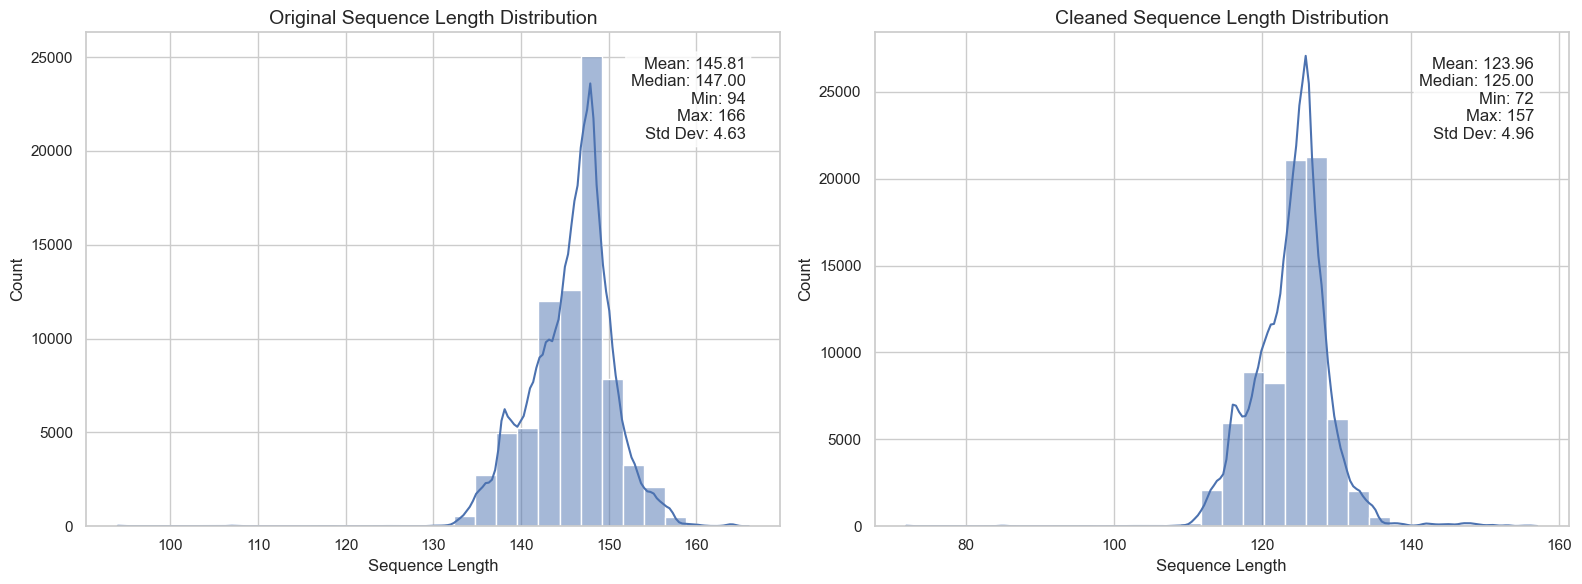

In [11]:
def plot_sequence_length_distribution(df_original, df_cleaned):
    """
    Plot the distribution of sequence lengths before and after cleaning.
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        Original dataframe before cleaning
    df_cleaned : pd.DataFrame
        Cleaned dataframe
    """
    # Calculate sequence lengths for original data
    df_original['original_length'] = df_original['VHH_sequence'].str.len()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot original sequence length distribution
    sns.histplot(df_original['original_length'], bins=30, kde=True, ax=ax1)
    ax1.set_title('Original Sequence Length Distribution', fontsize=14)
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    # Add statistics to the plot
    stats_text = f"Mean: {df_original['original_length'].mean():.2f}\n"
    stats_text += f"Median: {df_original['original_length'].median():.2f}\n"
    stats_text += f"Min: {df_original['original_length'].min()}\n"
    stats_text += f"Max: {df_original['original_length'].max()}\n"
    stats_text += f"Std Dev: {df_original['original_length'].std():.2f}"
    
    ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot cleaned sequence length distribution
    sns.histplot(df_cleaned['sequence_length'], bins=30, kde=True, ax=ax2)
    ax2.set_title('Cleaned Sequence Length Distribution', fontsize=14)
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    
    # Add statistics to the plot
    stats_text = f"Mean: {df_cleaned['sequence_length'].mean():.2f}\n"
    stats_text += f"Median: {df_cleaned['sequence_length'].median():.2f}\n"
    stats_text += f"Min: {df_cleaned['sequence_length'].min()}\n"
    stats_text += f"Max: {df_cleaned['sequence_length'].max()}\n"
    stats_text += f"Std Dev: {df_cleaned['sequence_length'].std():.2f}"
    
    ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'sequence_length_distribution_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Plot sequence length distribution
plot_sequence_length_distribution(df, df_final)

## 7. Visualize Class Distribution Before and After Cleaning

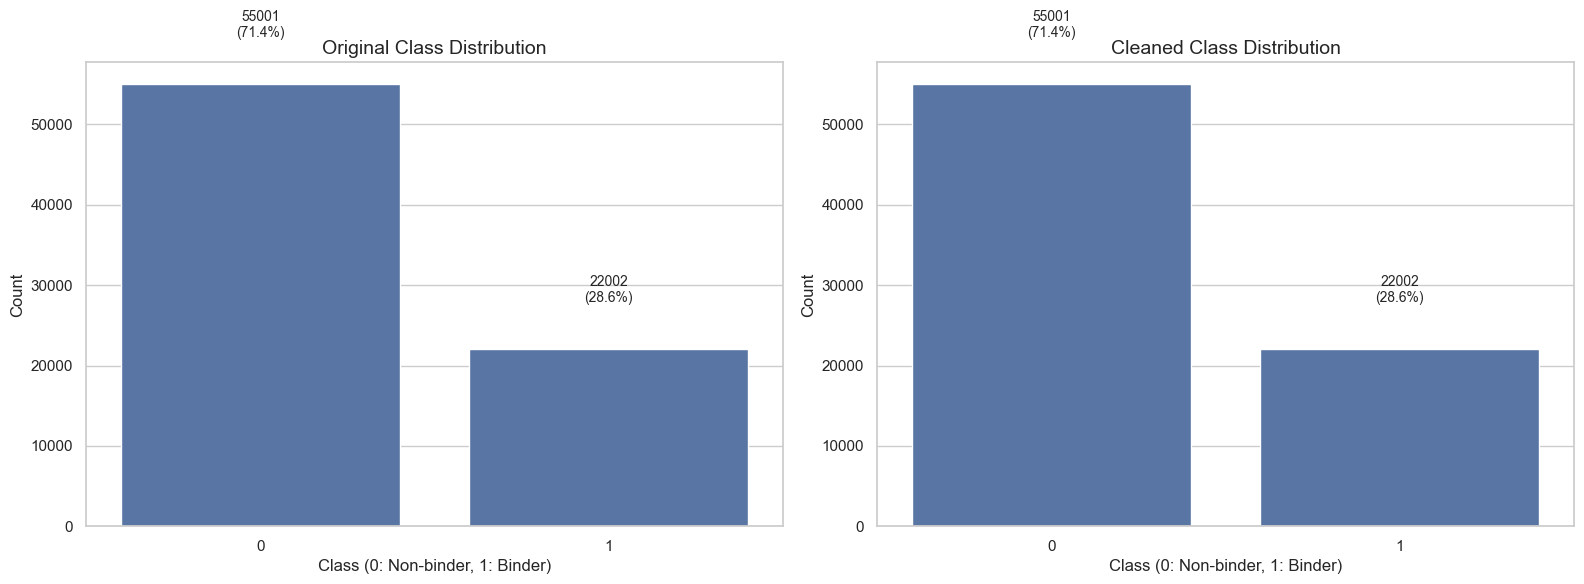

In [12]:
def plot_class_distribution(df_original, df_cleaned):
    """
    Plot the class distribution before and after cleaning.
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        Original dataframe before cleaning
    df_cleaned : pd.DataFrame
        Cleaned dataframe
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot original class distribution
    original_counts = df_original['label'].value_counts().sort_index()
    original_percentages = 100 * original_counts / len(df_original)
    
    sns.barplot(x=original_counts.index, y=original_counts.values, ax=ax1)
    ax1.set_title('Original Class Distribution', fontsize=14)
    ax1.set_xlabel('Class (0: Non-binder, 1: Binder)', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    # Add percentages to the bars
    for i, (count, percentage) in enumerate(zip(original_counts, original_percentages)):
        ax1.text(i, count + 0.1 * max(original_counts), 
                f'{count}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontsize=10)
    
    # Plot cleaned class distribution
    cleaned_counts = df_cleaned['label'].value_counts().sort_index()
    cleaned_percentages = 100 * cleaned_counts / len(df_cleaned)
    
    sns.barplot(x=cleaned_counts.index, y=cleaned_counts.values, ax=ax2)
    ax2.set_title('Cleaned Class Distribution', fontsize=14)
    ax2.set_xlabel('Class (0: Non-binder, 1: Binder)', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    
    # Add percentages to the bars
    for i, (count, percentage) in enumerate(zip(cleaned_counts, cleaned_percentages)):
        ax2.text(i, count + 0.1 * max(cleaned_counts), 
                f'{count}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'class_distribution_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Plot class distribution
plot_class_distribution(df, df_final)

## 8. Save Cleaned Data

In [13]:
def save_cleaned_data(df_cleaned):
    """
    Save the cleaned dataset to disk.
    
    Parameters:
    -----------
    df_cleaned : pd.DataFrame
        Cleaned dataframe to save
    """
    # Create output directory if it doesn't exist
    os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)
    
    # Save the cleaned data
    output_path = os.path.join(DATA_PROCESSED_DIR, 'cleaned_sequences.csv')
    df_cleaned.to_csv(output_path, index=False)
    print(f"Saved cleaned dataset to {output_path}")

# Save the cleaned data
save_cleaned_data(df_final)

Saved cleaned dataset to ../data/processed/cleaned_sequences.csv


## 9. Summary of Cleaning Process

In this notebook, we implemented a comprehensive cleaning and validation pipeline for amino acid sequences in the AVIDa-SARS-CoV-2 dataset. Here's a summary of the steps we took:

1. **Initial Validation**:
   - Checked for missing sequences
   - Identified sequences with invalid amino acid codes
   - Detected sequences that were too short or too long

2. **Sequence Pattern Analysis**:
   - Identified common prefixes and suffixes
   - Detected signal peptides that are common in antibody sequences

3. **Signal Peptide Processing**:
   - Identified sequences with signal peptides
   - Created mature sequences by removing signal peptides

4. **Invalid Amino Acid Handling**:
   - Replaced non-standard amino acids with appropriate substitutions
   - Removed any remaining invalid characters

5. **Missing and Truncated Sequence Handling**:
   - Identified sequences that were missing or had invalid lengths
   - Marked problematic sequences for removal

6. **Final Dataset Creation**:
   - Removed problematic sequences
   - Created a simplified dataset with only the necessary columns

7. **Visualization and Analysis**:
   - Visualized sequence length distribution before and after cleaning
   - Analyzed class distribution before and after cleaning

### Rationale Behind Cleaning Decisions

1. **Signal Peptide Removal**:
   - Signal peptides are cleaved during protein maturation and are not part of the functional antibody
   - Removing them helps focus on the functional part of the antibody that is involved in binding

2. **Non-Standard Amino Acid Substitution**:
   - Non-standard amino acids (B, Z, X, etc.) can cause issues with many analysis tools
   - We used biologically meaningful substitutions based on chemical properties

3. **Length Filtering**:
   - Very short sequences may be truncated or incomplete
   - Very long sequences may contain errors or additional protein segments
   - Filtering by length ensures we have complete, functional antibody sequences

4. **Removal vs. Imputation**:
   - We chose to remove problematic sequences rather than impute them
   - Imputation of amino acid sequences is complex and can introduce biases
   - With a large dataset, removing a small percentage of problematic sequences is preferable

The cleaned dataset maintains the class distribution and key characteristics of the original dataset while ensuring high data quality for downstream analysis and modeling.

## 10. Next Steps

With the cleaned dataset, we can now proceed to the next steps in our analysis:

1. **Handle Class Imbalance**: Address the imbalance between binders and non-binders
2. **Split Data**: Divide the data into training, validation, and test sets
3. **Feature Engineering**: Extract features from the amino acid sequences
4. **Model Development**: Train and evaluate machine learning models

These steps will be covered in subsequent notebooks.